In [1]:
import sys

sys.path.append('../../code/')
import os
import json
from datetime import datetime
import time
from math import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import rankdata

import igraph as ig

from load_data import load_citation_network, case_info

%load_ext autoreload
%autoreload 2
%matplotlib inline

data_dir = '../../data/'
court_name = 'scotus'

# load into igraph

In [2]:
start = time.time()
if court_name == 'all':
    case_metadata = pd.read_csv(data_dir + 'clean/case_metadata_master.csv')

    edgelist = pd.read_csv(data_dir + 'clean/edgelist_master.csv')
else:
    net_dir = data_dir + 'clean/' + court_name + '/'
    if not os.path.exists(net_dir):
        os.makedirs(net_dir)
        make_court_subnetwork(court_name, data_dir)

    case_metadata = pd.read_csv(net_dir + 'case_metadata.csv')

    edgelist = pd.read_csv(net_dir + 'edgelist.csv')
    edgelist.drop('Unnamed: 0', inplace=True, axis=1)

# create a dictonary that maps court listener ids to igraph ids
cl_to_ig_id = {}
cl_ids = case_metadata['id'].tolist()
for i in range(case_metadata['id'].size):
    cl_to_ig_id[cl_ids[i]] = i

# add nodes
V = case_metadata.shape[0]
g = ig.Graph(n=V, directed=True)
# g.vs['date'] = case_metadata['date'].tolist()
g.vs['name'] = case_metadata['id'].tolist()

# create igraph edgelist
cases_w_metadata = set(cl_to_ig_id.keys())
ig_edgelist = []
missing_cases = 0
start = time.time()
for row in edgelist.itertuples():

    cl_ing = row[1]
    cl_ed = row[2]

    if (cl_ing in cases_w_metadata) and (cl_ed in cases_w_metadata):
        ing = cl_to_ig_id[cl_ing]
        ed = cl_to_ig_id[cl_ed]
    else:
        missing_cases += 0
    
    ig_edgelist.append((ing, ed))

# add edges to graph
g.add_edges(ig_edgelist)

# add vertex attributes
g.vs['court'] =  case_metadata['court'].tolist()
g.vs['year'] = [int(d.split('-')[0]) for d in case_metadata['date'].tolist()]

end = time.time()

print '%d seconds for %d edges' % (end - start, len(g.es))

0 seconds for 250465 edges


In [3]:
# g.write_graphml(data_dir + 'clean/entire_law_net.graphml')
# G = ig.read_graphml(data_dir + 'clean/entire_law_net.graphml')

In [ ]:
# case_ranks = pd.DataFrame(index=range(len(g.vs)))
# case_ranks['id'] = g.vs['name']


# case_ranks['authority'] = rankdata(g.authority_score())
# case_ranks['indegree'] = rankdata(g.indegree())
# case_ranks['outdegree'] = rankdata(g.outdegree())
# case_ranks['hubs'] = rankdata(g.hub_score())
# case_ranks['betweenness'] = rankdata(g.betweenness())
# case_ranks['eigen'] = rankdata(g.eigenvector_centrality())
# case_ranks['closeness'] = rankdata(g.closeness())
# case_ranks['pagerank'] = rankdata(g.pagerank())
# case_ranks.to_csv('case_ranks_undirected.csv', index=False)

In [10]:
def plot_scatter_matrix(X):
    """
    Plots the scatter plot matrix for all variable in X, a pandas data frame

    """
    d = X.shape[1]
    cols = X.columns.tolist()

    plt.figure(figsize=[6 * d, 6 * d])
    p = 1
    for i in range(d):
        for j in range(d):

            if i < j:
                xvar = cols[j]
                yvar = cols[i]

                # scatter plot of ith vs jth variable
                plt.subplot(d, d, p)
                plt.scatter(X[xvar], X[yvar], color='black', alpha=.7)
                plt.xlabel(xvar)
                plt.ylabel(yvar)

                # add correlation coefficient
                corr_coef = X.corr(method='pearson').loc[xvar, yvar]
                plt.annotate('corr: %1.3f' % corr_coef,
                             xy=(0.8, 0.92),
                             xycoords='axes fraction',
                             color='red')

            p += 1


# analyze metrics

In [3]:
case_ranks_dir = pd.read_csv(data_dir + 'analysis/case_ranks_directed.csv')

In [4]:
case_ranks_dir

,id,authority,indegree,outdegree,hubs,betweenness,eigen,closeness,pagerank
0,100000,12015.0,10804.0,4521.0,3486.0,7149.5,18755.0,7176.0,9995.0
1,100001,11530.0,10804.0,4521.0,3486.0,7149.5,18133.0,8035.0,13754.0
2,100002,25857.0,23025.0,16651.0,16226.0,23436.0,22836.0,23934.5,15651.0
3,100003,27082.0,28004.5,14433.5,22337.0,19454.0,23911.0,25721.0,23429.0
4,100004,18385.0,18764.5,11122.5,15040.0,7149.5,24813.0,16038.0,19071.0
5,100005,24551.0,24945.0,26457.5,24920.0,29746.0,26229.0,28921.5,24132.0
6,100006,14583.0,20420.0,14433.5,14063.0,20167.0,22452.0,10788.0,26243.0
7,100007,24592.0,30215.0,22431.5,20318.0,30204.0,26655.0,26332.0,28954.0
8,100008,3025.0,4241.5,4521.0,3486.0,7149.5,5317.5,2239.0,4241.5
9,100009,24279.0,30215.0,26457.5,21466.0,25742.0,26161.0,27459.0,28433.0


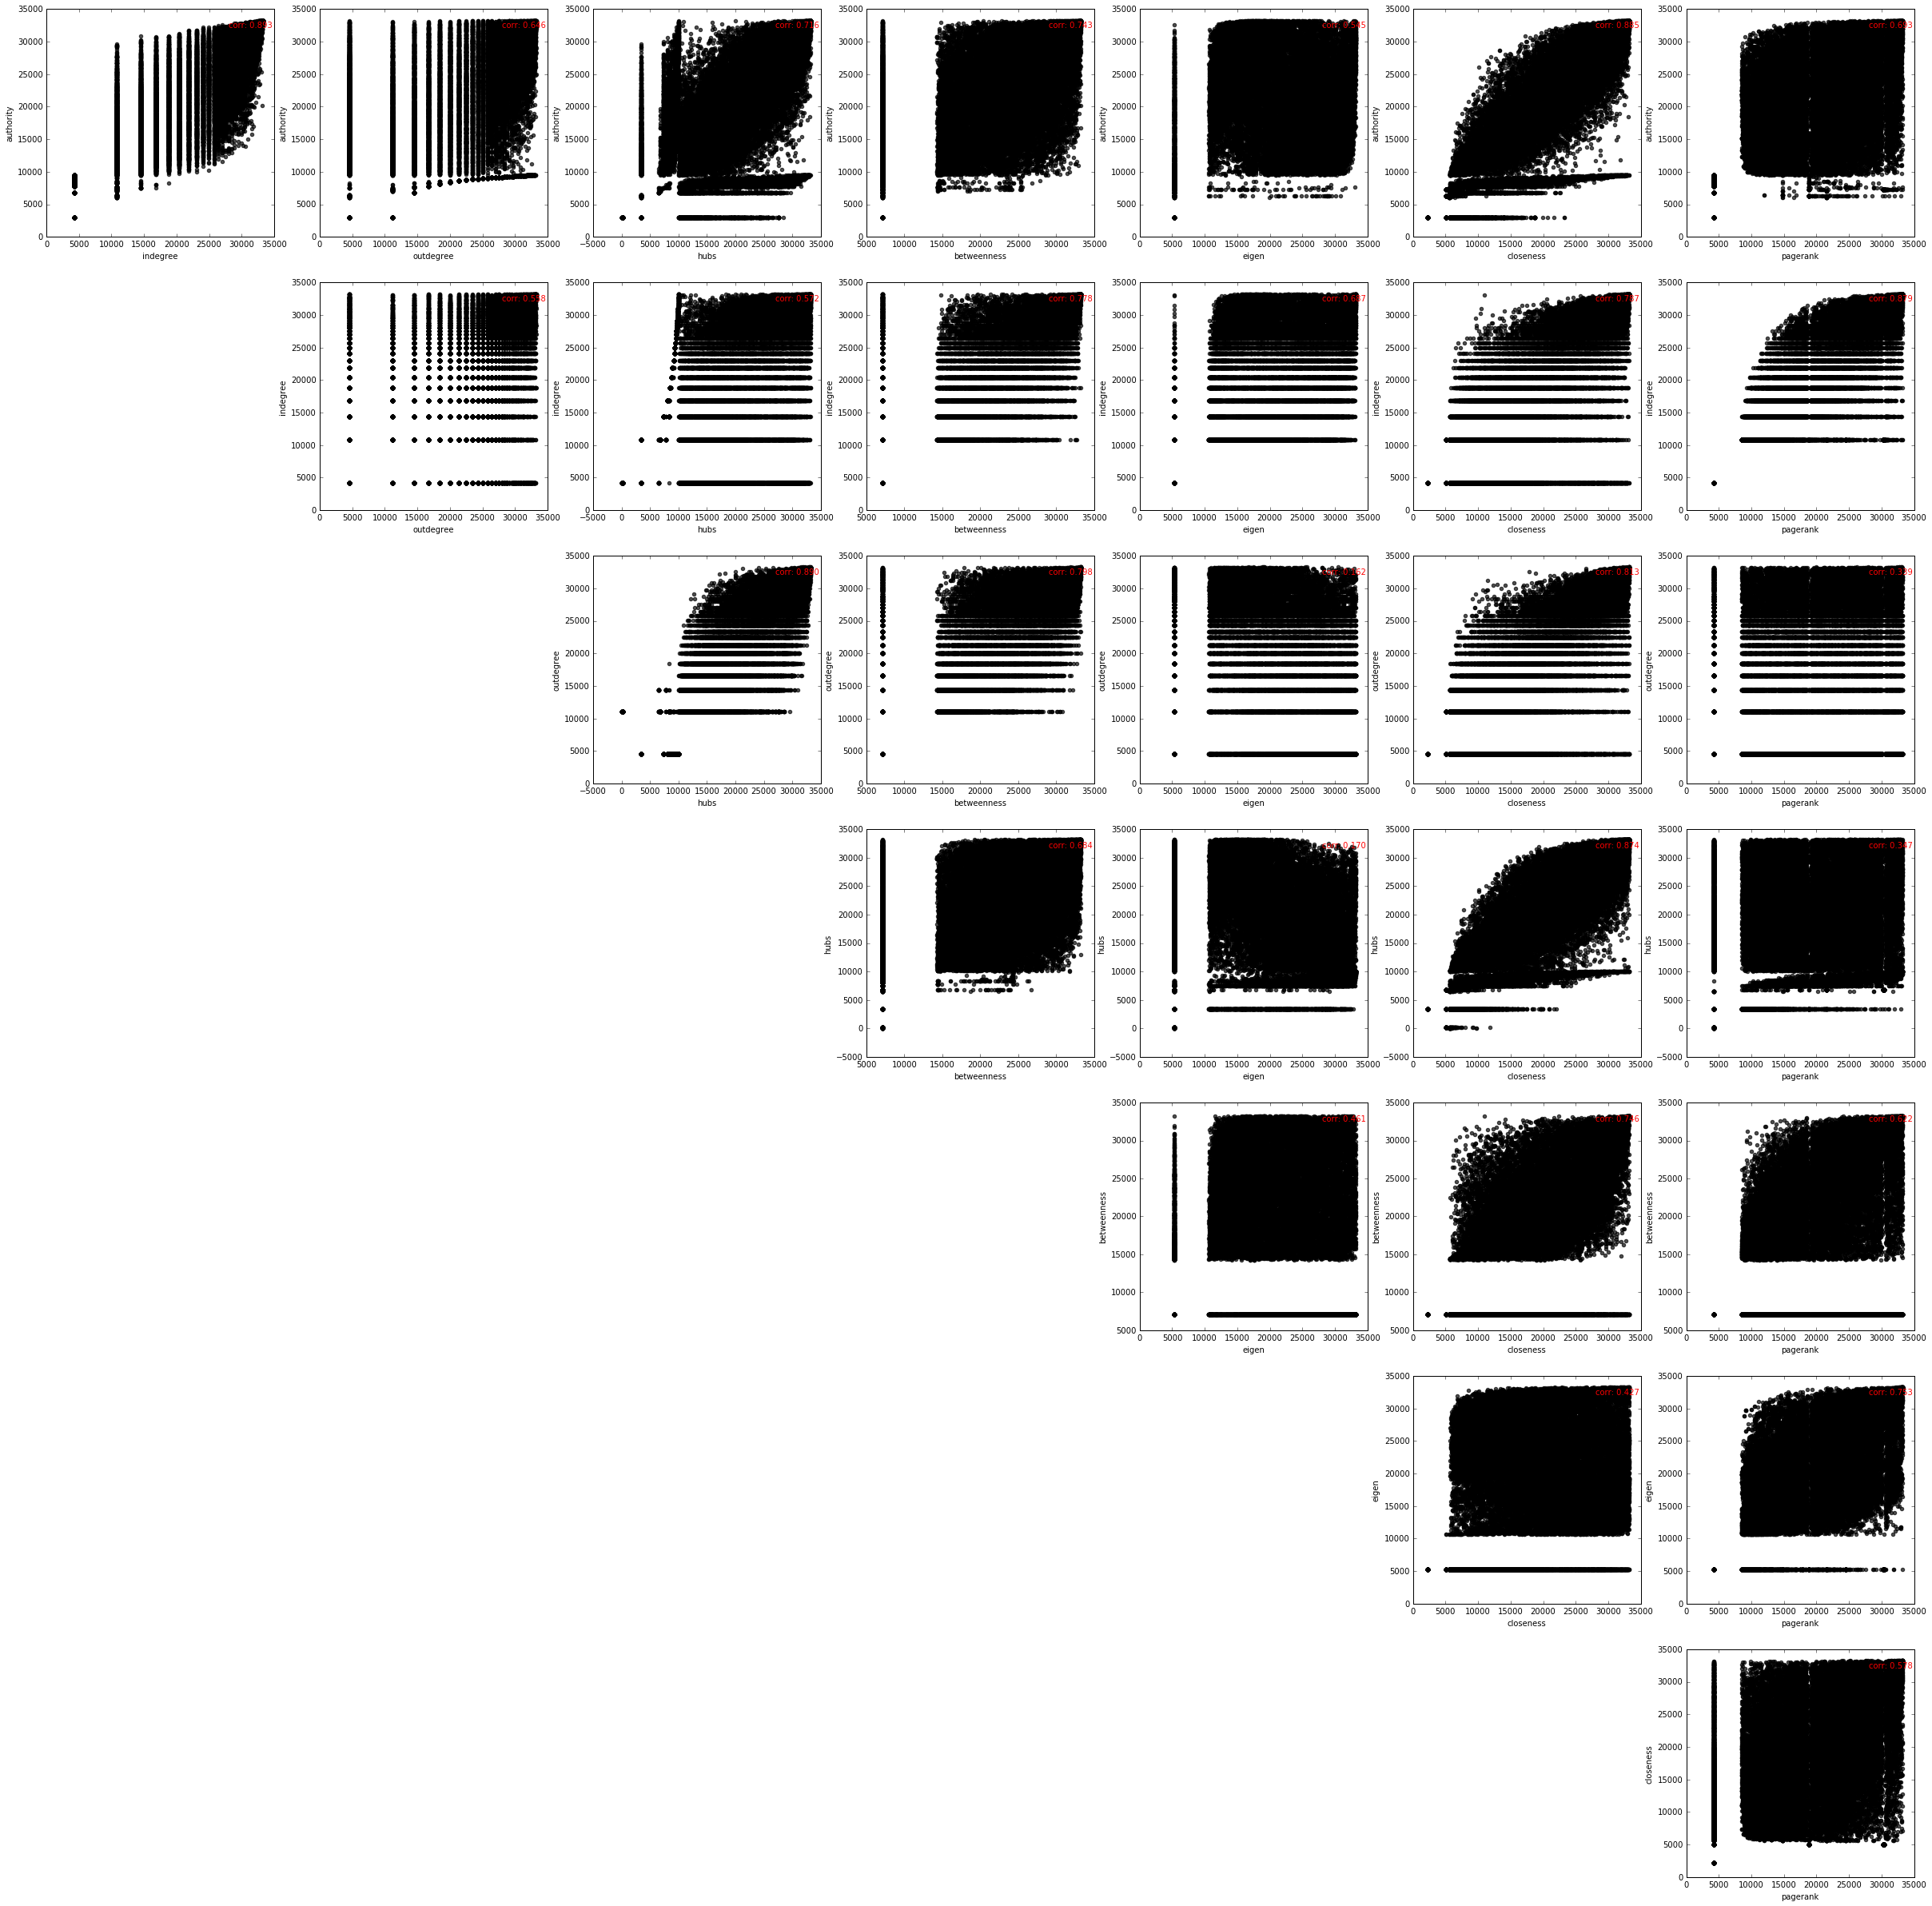

In [11]:
plot_scatter_matrix(case_ranks_dir.drop('id', axis=1))

In [24]:
case_ranks_dir.sort_values('indegree', ascending=False)

,id,authority,indegree,outdegree,hubs,betweenness,eigen,closeness,pagerank
29701,96405,33231.0,33248.0,31657.5,20035.0,32760.0,26504.0,33244.0,33184.0
9366,109532,33121.0,33247.0,30241.5,32027.0,33232.0,16410.0,32412.5,33234.0
6889,107252,33216.0,33246.0,33155.5,33084.0,33231.0,18486.0,33175.0,33174.0
24956,91573,33226.0,33245.0,4521.0,10079.0,7149.5,32783.0,33216.0,33247.0
6248,106545,33209.0,33244.0,32778.0,33153.0,33242.0,19237.0,33212.0,33235.0
11048,111221,32709.0,33243.0,32531.5,28669.0,33164.0,14579.0,33055.0,33044.0
2516,102605,33235.0,33242.0,33203.0,32417.0,33248.0,24492.0,33248.0,32990.0
2891,103012,33052.0,33241.0,32747.0,28862.0,33245.0,23245.0,33247.0,33155.0
3212,103355,33248.0,33240.0,24278.0,32173.0,29602.0,24449.0,33102.0,33128.0
6451,106761,33245.0,33239.0,32531.5,33178.0,33081.0,19051.0,33118.0,32966.0


In [26]:
case_info('96405')

United States v. Detroit Timber & Lumber Co.
1906-02-19

https://www.courtlistener.com/opinion/96405/united-states-v-detroit-timber-lumber-co/



array([ 10804. ,  10804. ,  23025. , ...,  10804. ,  25740. ,  16826.5])

In [29]:
rankdata(-case_ranks_dir['indegree'])

array([ 22445. ,  22445. ,  10224. , ...,  22445. ,   7509. ,  16422.5])